In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special
import math
import ipywidgets
%matplotlib inline

In [2]:
def gaussian_orthogonal_ensemble(n : int, d:int) -> np.array:
    v = np.random.normal(size=(n,d))
    A = v.dot(v.T)
    D = np.outer(A.diagonal(), A.diagonal())
    D = np.sqrt(D)
    A /= D
    return A

In [3]:
def erdos_renyi(n : int, p : int) -> np.array:
    A = np.random.uniform(size=(n,n))
    for i in range(n):
        A[i,i] = 0
        for j in range(i):
            A[i,j] = A[j,i]
    A = ( A > 1-p ).astype(int)
    return A

In [4]:
def laplacian(A : np.array) -> np.array:
    return -A + np.diag(A.dot(np.ones(A.shape[0])))

In [5]:
def density_from_threshold(d: int, h : float) -> float:
    if h > 1:
        return 1 - density_from_threshold(d, 2-h)
    return scipy.special.betainc((d-1)/2, 1/2, 2*h - h*h)/2

In [6]:
def invert(y, f, low=0, high=2, accuracy = 1e-9):
    while high-low > accuracy:
        mid = (high+low)/2
        if f(mid) < y:
            low = mid
        else:
            high = mid
    return low

In [7]:
def gr_graph(n : int, p : float, d : int) -> np.array:
    h = threshold_from_density(d, p)
    A = gaussian_orthogonal_ensemble(n, d)
    A = (A > 1 - h).astype(int)
    for i in range(A.shape[0]):
        A[i,i] = 0
    return A

In [8]:
def threshold_from_density(d : int, p : float) -> float:
    return invert(p, lambda x: density_from_threshold(d, x), accuracy=1e-15)

In [9]:
def adjecency_lists(A):
    adj_lists = []
    for i in range(A.shape[0]):
        adj_lists.append(np.where(A[i,:] == 1)[0])
    return adj_lists

In [10]:
def square_sparse_matrix(A):
    A_sq = np.zeros(shape=A.shape)
    adj_lists = adjecency_lists(A)
    for i in range(A.shape[0]):
        for u in adj_lists[i]:
            for v in adj_lists[u]:
                A_sq[i, v] += A[i,u]*A[u,v]
    return A_sq

In [11]:
def mult_by_sparse_matrix(A, B, adj=None):
    if adj is None:
        adj = adjecency_lists(B)
    res = np.zeros(shape = (A.shape[0], B.shape[1]))
    for i in range(B.shape[1]):
        for neigh in adj[i]:
            res[:, i] += A[:, neigh]*B[neigh,i]
    return res

In [12]:
def common_neighbors_statistics(A, sparse=True):
    if sparse:
        common_neighbors = square_sparse_matrix(A)
    else:
        common_neighbors = A.dot(A)
    connected_cn = []
    unconnected_cn = []
    for i in range(A.shape[0]):
        for j in range(i):
            if A[i,j] == 1:
                connected_cn.append(common_neighbors[i,j])
            else:
                unconnected_cn.append(common_neighbors[i,j])
    return (connected_cn, unconnected_cn)

In [13]:
def prepare_all_plots(A : np.array, bins_cnt = 50, sparse=True) -> dict:
    res = {}
    
    w = np.linalg.eigvalsh(laplacian(A))
    counts, bins = np.histogram(w[1:], bins=100)
    res["spectrum"] = ("Spectrum density", bins, counts)
    
    degs = A.dot(np.ones(A.shape[0]))
    bin_width = int( (max(degs) - min(degs))/bins_cnt ) + 1
    bins = np.linspace(0, bins_cnt - 1, bins_cnt)*bin_width + min(degs)
    counts, bins = np.histogram(degs, bins=bins)
    res["degrees"] = ("Degree distribution", bins, counts)
    
        
    if sparse:
        bins = np.linspace(0, 20,21)
    else:
        bins = np.linspace(0, max(degs), bins_cnt)
    con, uncon = common_neighbors_statistics(A, sparse=sparse)
    counts,bins = np.histogram(con, bins=bins,density = True)
    res["neigh_connected"] = ("Common neighbors of connected vertices", bins, counts)
    
    counts,bins = np.histogram(uncon, bins=bins, density=True)
    res["neigh_unconnected"] = ("Common neighbors of unconnected vertices", bins, counts)

    return res

In [14]:
def show_plots(plots, shape, plots_ids, axs = None):
    if axs is None:
        _, axs = plt.subplots(shape[0], shape[1], figsize=(20,15), squeeze=False)
    for i in range(shape[0]):
        for j in range(shape[1]):
            current_plot = plots[plots_ids[i][j]]
            axs[i,j].clear()
            axs[i,j].set_xlabel(current_plot[0])
            axs[i,j].hist(current_plot[1][:-1], bins = current_plot[1], weights = current_plot[2])
    return axs

## Geometric random graph $n=4000$, $p=10/4000$ (i.e. average degree is $10$), $d=10$

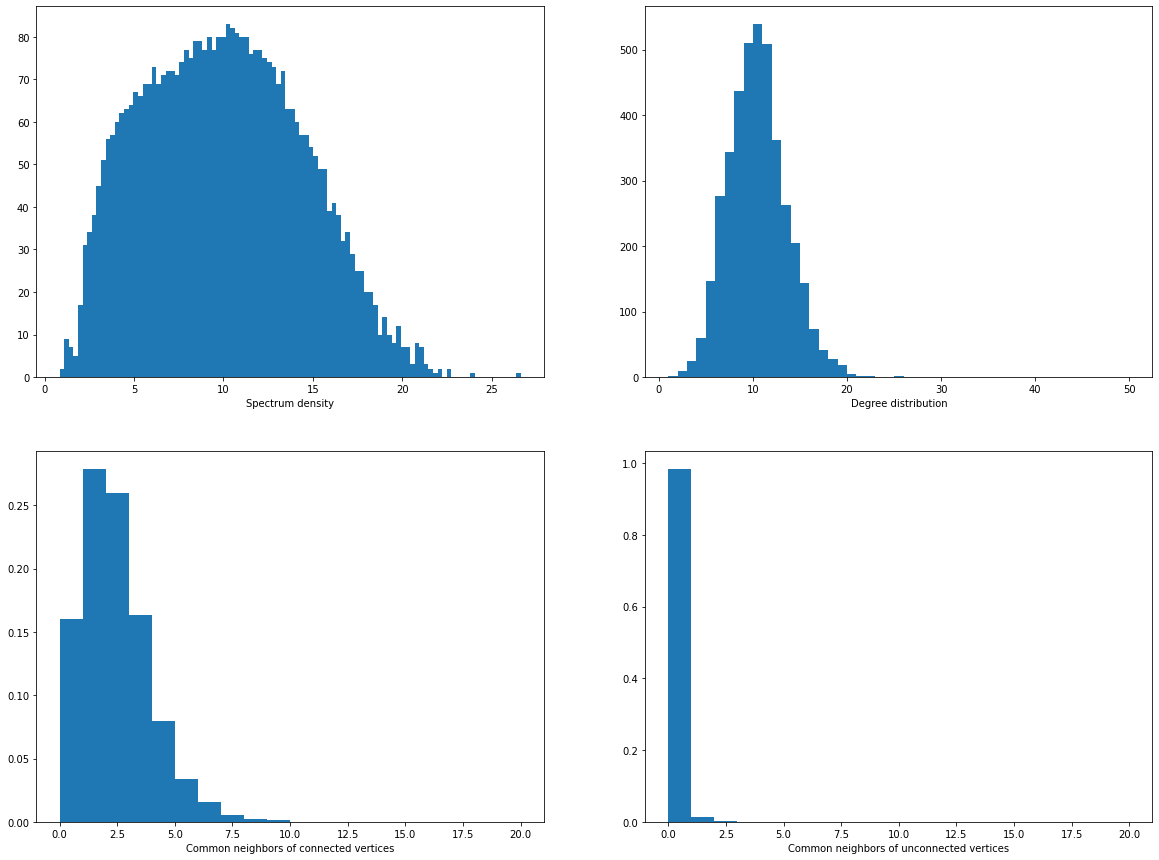

In [54]:
A_gr_ld = gr_graph(4000, 10/4000, 10)
plots = prepare_all_plots(A_gr_ld)
_ = show_plots(plots, (2,2), [["spectrum","degrees"], ["neigh_connected", "neigh_unc1onnected"]])

## Geometric random graph $n=4000$, $p=10/4000$ (i.e. average degree is $10$), $d=50$

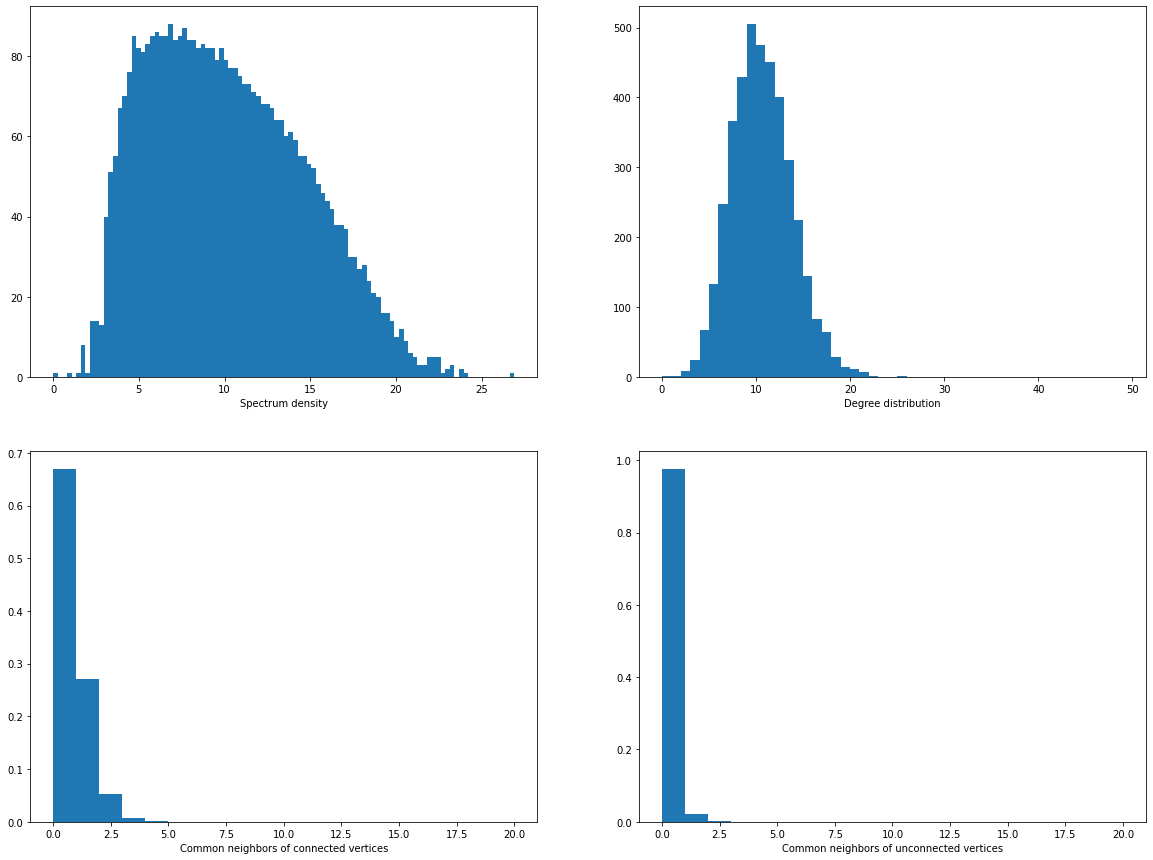

In [15]:
A_gr = gr_graph(4000, 10/4000, 50)
plots = prepare_all_plots(A_gr)
_ = show_plots(plots, (2,2), [["spectrum","degrees"], ["neigh_connected", "neigh_unconnected"]])

## Erdos-Renyi graph $G(n,p)$, $n=4000$, $p=10/4000$ (i.e. average degree $10$)

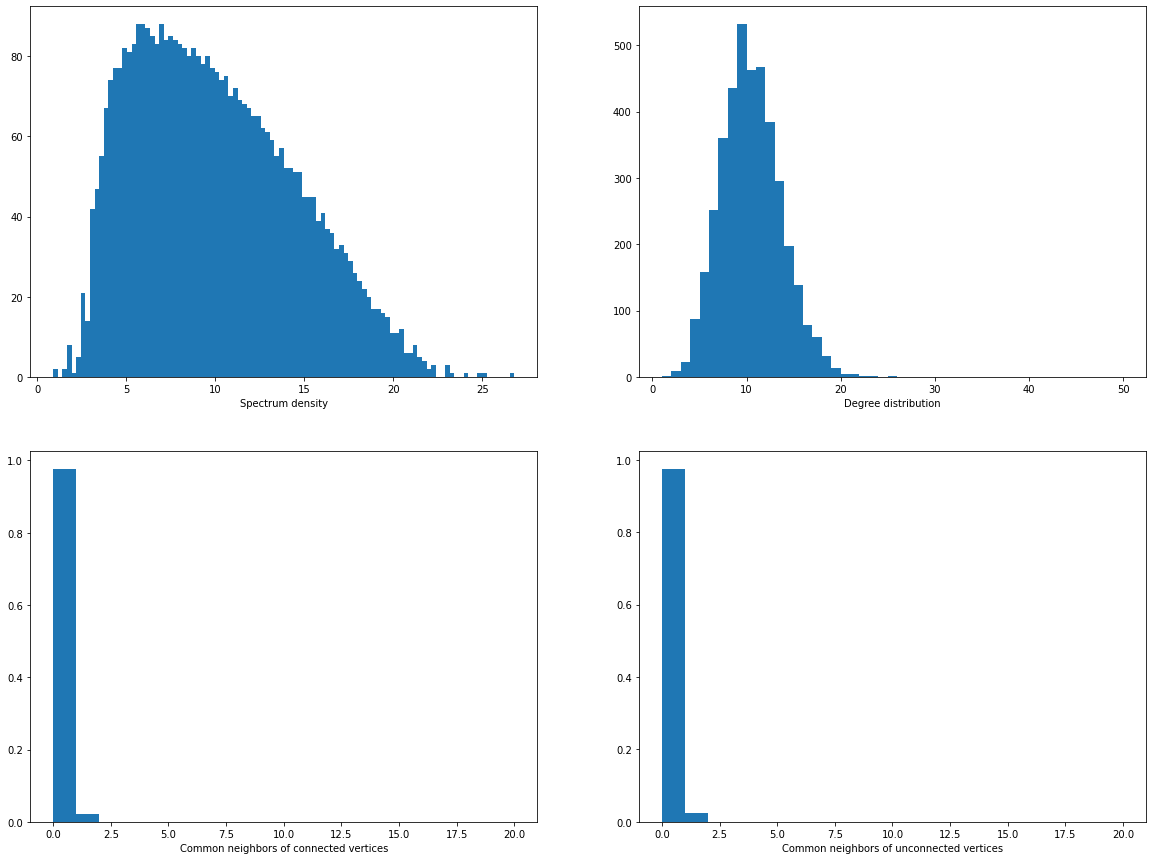

In [77]:
A = erdos_renyi(4000, 10/4000)
plots = prepare_all_plots(A)
_ = show_plots(plots, (2,2), [["spectrum","degrees"], ["neigh_connected", "neigh_unconnected"]])

## GR(4000, 1/2, 50)

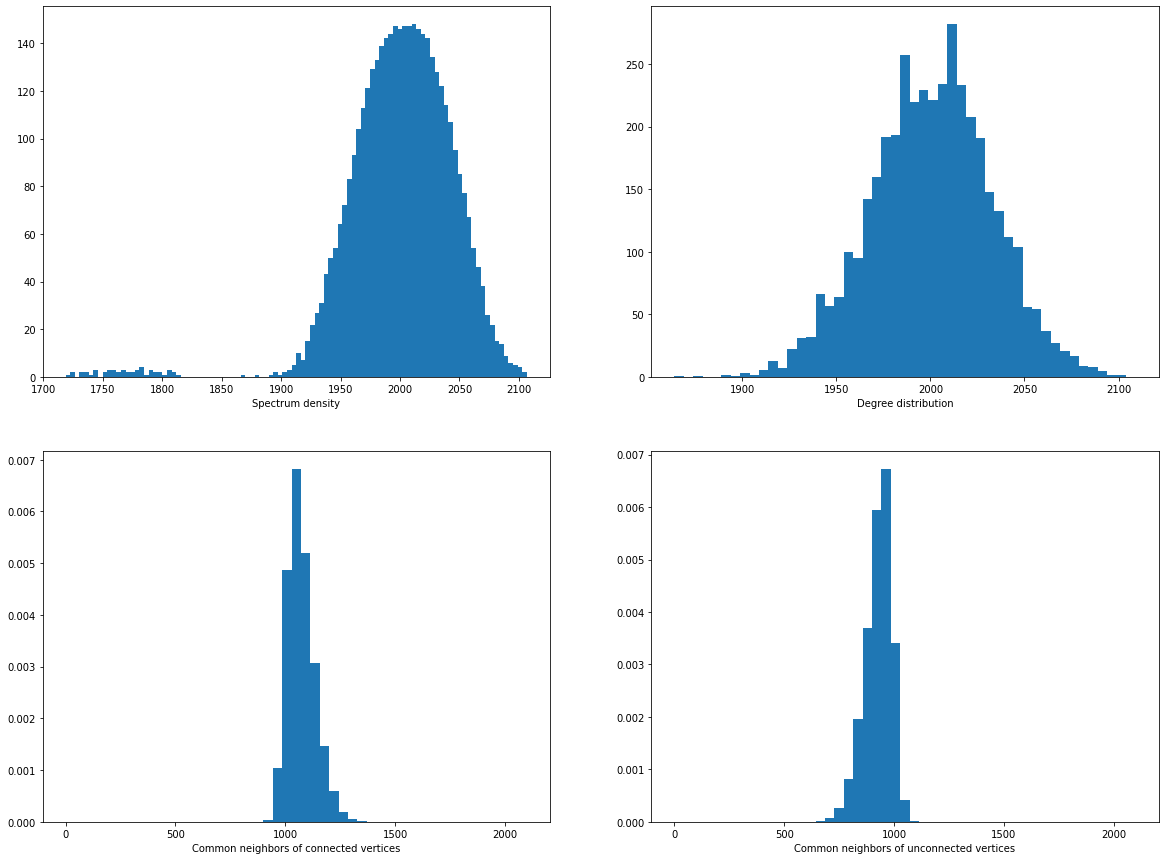

In [52]:
A_gr_dense = gr_graph(4000, 1/2, 50)
plots = prepare_all_plots(A_gr_dense, sparse=False)
_ = show_plots(plots, (2,2), [["spectrum","degrees"], ["neigh_connected", "neigh_unconnected"]])

## G(4000, 1/2)

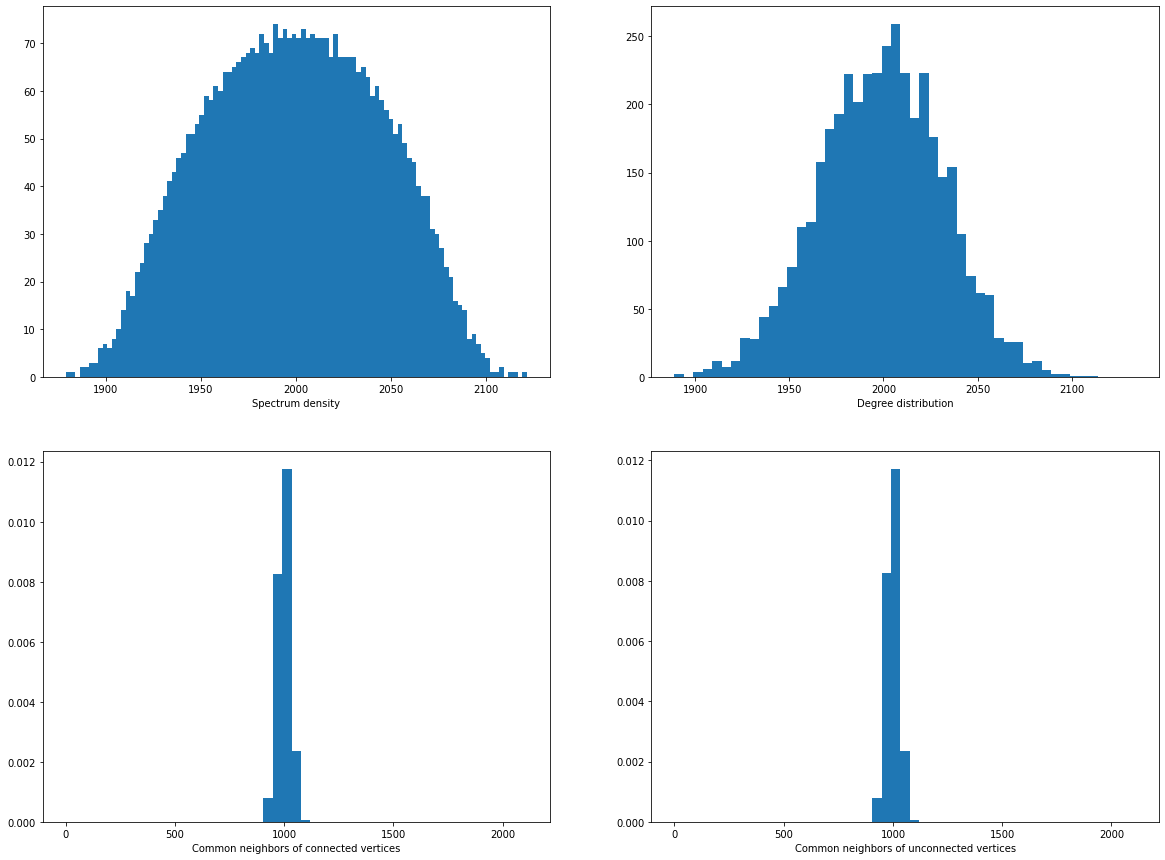

In [53]:
A_dense = erdos_renyi(4000, 1/2)
plots = prepare_all_plots(A_dense, sparse=False)
_ = show_plots(plots, (2,2), [["spectrum","degrees"], ["neigh_connected", "neigh_unconnected"]])

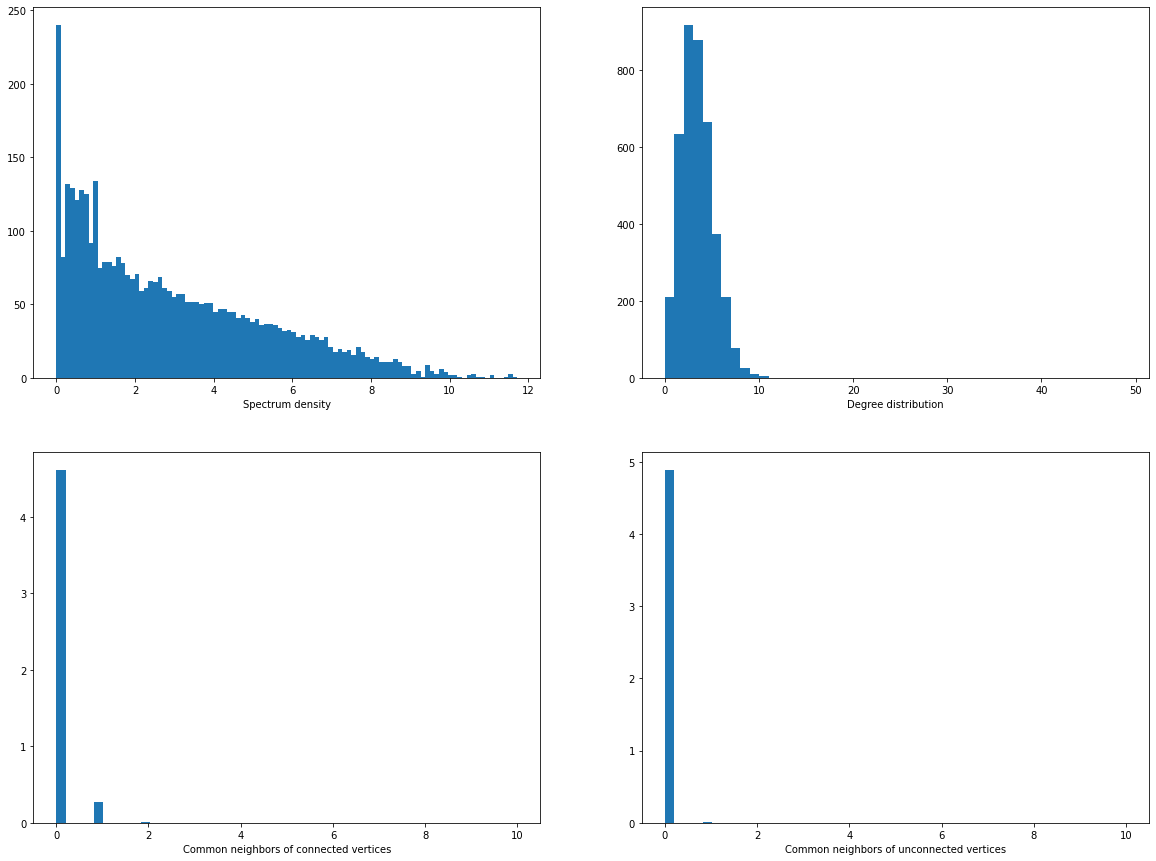

In [42]:
A_gr_us = gr_graph(4000, 3/4000, 50)
plots = prepare_all_plots(A_gr_us, sparse=False)
_ = show_plots(plots, (2,2), [["spectrum","degrees"], ["neigh_connected", "neigh_unconnected"]])

In [20]:
d=10.
xs = []
ys = []
all_plots_list = []
while d < 500.:
    print(int(d))
    xs.append(int(d))
    A_gr_tmp = gr_graph(4000, 10/4000, int(d))
    con, uncon = common_neighbors_statistics(A_gr_tmp, sparse=True)
    thresholding_alg = sum([1 if t >= 1 else 0 for t in con])
    thresholding_success_rate = thresholding_alg / len(con)
    ys.append(thresholding_success_rate)
    d = d *1.4
    all_plots_list.append(prepare_all_plots(A_gr_tmp))

10
14
19
27
38
53
75
105
147
206
289
404


In [21]:
def plot_precission(xs, ys, d, axs = None):
    if axs is None:
        fig = plt.figure()
        axs = fig.subplots()
    axs.clear()
    axs.plot(xs, ys)
    axs.set_xlabel("dimension")
    axs.set_ylabel("Pr[x and y has common neighbor | x ~ y]")
    axs.set_title("Edge prediction based on existance of common neighbor, n=4000, p=10/4000")
    axs.axvline(d, color="red")
    return axs

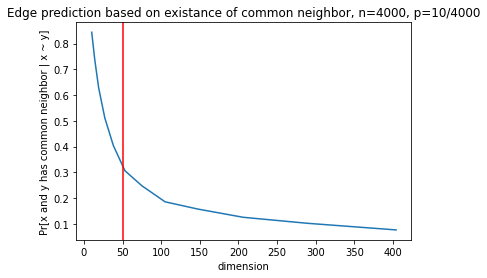

In [22]:
cur_dim_axs = plot_precission(xs, ys, 50)

## Comparing effective resistances

Using Shermann-Morrison formula to compute effective resistance of $e_i - e_j$ with respect to $L - (e_i - e_j) (e_i - e_j)^T$, when $(i,j)$ is an edge of the graph. If $v := e_i - e_j$, and $t := v^T L^+ v$, we have

$$v(L - v v^T)^{-1} v^T = v^T\left(L^{-1} + \frac{L^{-1}vv^TL^{-1}}{1 - v^T L^{-1}v}\right) v = t + \frac{t^2}{1-t}$$

In [23]:
def effective_resistance_fixed(A, Li, i, j):
    t = Li[i,i] + Li[j,j] - 2*Li[i,j]
    #return t

    if A[i,j] == 0:
        return t
    else:
        return t + t*t/(1-t)

In [24]:
def all_effective_resistances(A):
    ER = np.zeros(shape=A.shape)
    Li = np.linalg.pinv(laplacian(A))
    for i in range(A.shape[0]):
        for j in range(i):
            ER[i,j] = ER[j,i] = effective_resistance_fixed(A, Li, i, j)
    return ER

In [25]:
def plot_effective_resistances_histogram(A):
    ER = all_effective_resistances(A)
    con = []
    uncon = []
    for i in range(A_gr_ld.shape[0]):
        for j in range(i):
            if ER[i,j] < 0.01:
                continue
            if A_gr_ld[i,j] == 1:
                con.append(ER[i,j])
            else:
                uncon.append(ER[i,j])
    _= plt.hist(uncon, bins=50, range=(0,0.5), density=True)
    _ = plt.hist(con, bins=50, range=(0, 0.5), density=True, alpha=0.8)
    return (con, uncon)

### Comparing distribution of effective resistances for GR(n,p,d)
Distribution of effective resistance on vertices connected by an edge (affter correcting for hiding the edge), and not connected.

First plot is $GR(n=4000, p=10/4000, d=10)$. (i.e. average degree $10$, dimension $d=10$.

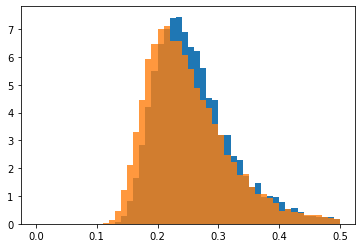

In [26]:
_ = plot_effective_resistances_histogram(A_gr_ld)

### GR(n=4000, p=10/4000, d=50)

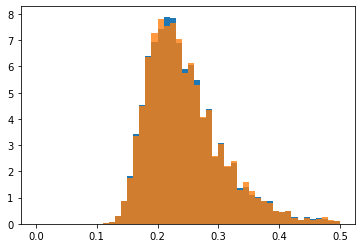

In [27]:
con, uncon = plot_effective_resistances_histogram(A_gr)

In [28]:
mu = sum(con)/len(con)
err = np.sqrt(sum([(t-mu)*(t-mu) for t in con])/len(con))

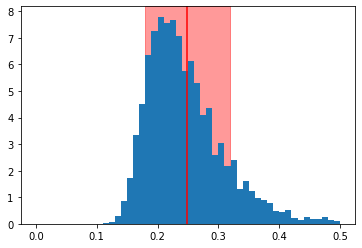

In [29]:
plt.axvspan(mu-err, mu+err, color="red", alpha=0.4)
_ = plt.hist(con, bins=50, range=(0, 0.50), density=True)
plt.axvline(mu, color="red")


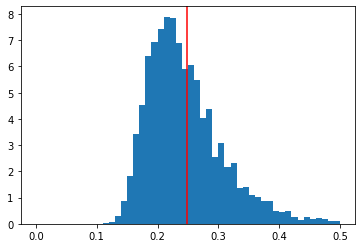

In [30]:
_= plt.hist(uncon, bins=50, range=(0, 0.50), density=True)
plt.axvline(sum(uncon)/len(uncon), color="red")

## Comparing number of length 3 paths
$GR(n=4000, p=10/4000, d=50)$

In [30]:
def length_3_paths(A):
    con = []
    uncon = []
    A_sq = square_sparse_matrix(A)
    A_cb = mult_by_sparse_matrix(A_sq, A)
    con_short_paths = 0
    uncon_short_paths = 0
    for i in range(A.shape[0]):
        for j in range(i):
            if A[i,j] == 1:
                pc = A_cb[i,j] - A_sq[i,i] - A_sq[j,j] + 1
                con.append(pc)
                if pc >= 2 or A_sq[i,j] > 0:
                    con_short_paths+=1
            else:
                uncon.append(A_cb[i,j])
                if A_cb[i,j] >= 2 or A_sq[i,j] > 0:
                    uncon_short_paths += 1
    return (con, uncon, con_short_paths/len(con), uncon_short_paths/len(uncon))

In [48]:
con,uncon, csp, usp = length_3_paths(A_gr_us)

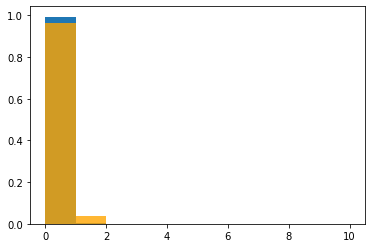

In [49]:
unconh = plt.hist(uncon, density=True, bins = np.linspace(0, 10, 11))
conh = plt.hist(con, density=True, bins = np.linspace(0, 10, 11), alpha=0.8, color="orange")

In [52]:
csp

0.05793408086986069

In [53]:
usp

0.0022208141675656777

In [41]:
sum(conh[0][2:])

0.255050505050505

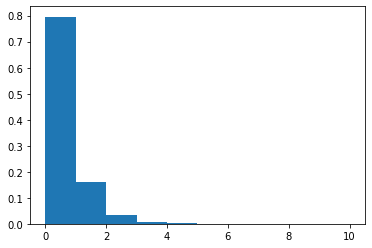

In [34]:
_ = plt.hist(uncon, density=True, bins = np.linspace(0, 10, 11))

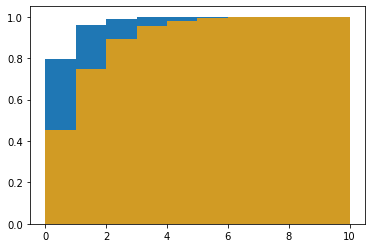

In [46]:
_ = plt.hist(uncon, density=True, bins = np.linspace(0, 10, 11), cumulative=True)
_ = plt.hist(con, density=True, bins = np.linspace(0, 10, 11), cumulative=True, color="orange", alpha=0.8)

## Projection onto top eigenvectors

In [17]:
def projection_statistic(A, f):
    con = []
    uncon = []
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            if A[i,j] == 1:
                con.append(f(i,j))
            else:
                uncon.append(f(i,j))
    return con,uncon

In [44]:
def display_comparison_plot(con, uncon):
    unconh = plt.hist(uncon, density=True, bins=50)
    conh = plt.hist(con, density=True, bins=50, alpha=0.8, color="orange")
    
    avg_con = sum(con)/len(con)
    avg_uncon = sum(uncon)/len(uncon)
    threshold = (avg_con + avg_uncon)/2
    false_positive = sum((np.array(con) > threshold).astype(int))/len(con)
    false_negative = sum((np.array(uncon) < threshold).astype(int))/len(uncon)
    plt.axvline(avg_con, color="red")
    plt.axvline(avg_uncon, color="red")
    print(f"{false_positive=} and {false_negative=}")

    return (false_positive, false_negative)
    

In [19]:
def prepare_projection_plot(A, d_proj = 50, U = None):
    if U is None:
        _, U = np.linalg.eigh(A)
    f = lambda x,y : np.linalg.norm(U[x, -d_proj:] - U[y, -d_proj:])
    con, uncon = projection_statistic(A, f)
    return con,uncon

In [20]:
sigma, U = np.linalg.eigh(A_gr)

### GR(n=2000, p=10/2000, d=50)

Projecting onto top 30 eigenvectors of the laplacian --- projecting on the original Laplacian

false_positive=0.28338204172125364 and false_negative=0.4193295033307756


NameError: name 'false_positive' is not defined

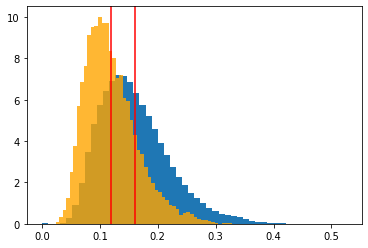

In [52]:
con,uncon = prepare_projection_plot(A_gr_small, d_proj = 30)
display_comparison_plot(con, uncon)

In [25]:
def gramm_schmidt(U):
    for i in range(U.shape[0]):
        for j in range(i):
            U[i, :] -= U[j, :] * U[j,:].dot(U[i,:])
        U[i, :] /= np.linalg.norm(U[i, :])

In [41]:
def sparse_power_iteration(U, A, iters=3, adj = None):
    if adj is None:
        adj = adjecency_lists(A)
    for _ in range(iters):
        U[:,:] = mult_by_sparse_matrix(U, A, adj=adj)
        gramm_schmidt(U)
    

In [42]:
def get_distance(A, U, i, j, adj):
    if A[i,j] == 0:
        return np.linalg.norm(U[:,i] - U[:, j])
        
    A[i,j] = A[j,i] = 0
    sparse_power_iteration(U, A, iters=4, adj = adj)
    A[i,j] = A[j,i] = 1
    return np.linalg.norm(U[:, i] - U[:,j])

In [55]:
A_gr_small = gr_graph(2000, 10/2000, 50)
sigma, U = np.linalg.eigh(A_gr_small)

In [56]:
adj_lists = adjecency_lists(A_gr_small)
Ucp = U[:, -30:].T.copy()
con, uncon = projection_statistic(A_gr_small, lambda x,y: get_distance(A_gr_small, Ucp, x, y, adj_lists))

### Projecting on a Laplacian after removing the potential edge

The same plot, as above after correcting for hiding the edge that we want to predict

false_positive=0.3907294681169544 and false_negative=0.5046789438481512


(0.3907294681169544, 0.5046789438481512)

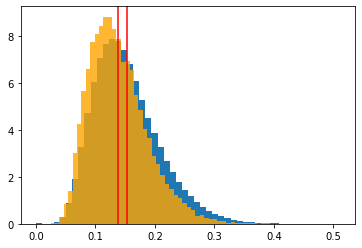

In [57]:
display_comparison_plot(con, uncon)

In [ ]:
xs = []
ys = []
d = 3.01
while d < 400:
    dd = int(d)
    print(f"{dd=}")
    _,_,false_positive, false_negative = prepare_projection_plot(A_gr, d_proj = dd, U = U)
    xs.append(dd)
    ys.append((false_positive, false_negative))
    d *= 1.5

In [107]:
u, v = zip(*ys)

In [114]:
?plt.plot

## GR(n=4000, p=10/4000, d=50)

False positive rate + false negative rate vs projection dimension

(Projection on the top $t$ eigenvectors of the Laplacian of the original graph --- without correcting for removing the edge)

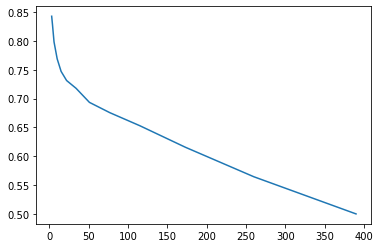

In [121]:
plt.plot(xs, [t[0] + t[1] for t in ys])

## Scratch stuff...

In [44]:
def BFS(A, adj_lists, start, stop):
    distance = np.full(A.shape[0], -1, dtype=int)
    queue = np.zeros(A.shape[0], dtype=int)
    head = 0
    tail = 0
    distance[start] = 0
    queue[head]=start
    head += 1 
    while head > tail:
        cur = queue[tail]
        tail += 1
        for neigh in adj_lists[cur]:
            if cur == start and neigh == stop:
                continue
            if distance[neigh] == -1:
                distance[neigh] = distance[cur]+1
                queue[head] = neigh
                head += 1
            if neigh == stop:
                break
    return distance[stop]

In [47]:
BFS(A_gr_us, adjecency_lists(A_gr_us), 0, 12)

7

In [63]:
A = np.ones(shape=(4,4))

In [64]:
np.linalg.eigh(A)

(array([-9.89816667e-16, -3.42450962e-16, -1.23259516e-32,  4.00000000e+00]),
 array([[-7.95140162e-01, -3.43150291e-01, -7.41676339e-18,
          5.00000000e-01],
        [ 5.88571918e-01, -6.35281904e-01, -2.25877598e-16,
          5.00000000e-01],
        [ 1.03284122e-01,  4.89216098e-01, -7.07106781e-01,
          5.00000000e-01],
        [ 1.03284122e-01,  4.89216098e-01,  7.07106781e-01,
          5.00000000e-01]]))

In [ ]:
plt.ion()

In [43]:
def slider_callback(i):
    plot_precission(xs, ys, xs[i], axs=cur_dim_axs)
    show_plots(all_plots_list[i], (2,2), [["spectrum","degrees"], ["neigh_connected", "neigh_unconnected"]], axs=axs)

In [44]:
ipywidgets.interact(slider_callback, i=(0, len(xs)-1))

interactive(children=(IntSlider(value=5, description='i', max=11), Output()), _dom_classes=('widget-interact',…

<function __main__.slider_callback(i)>

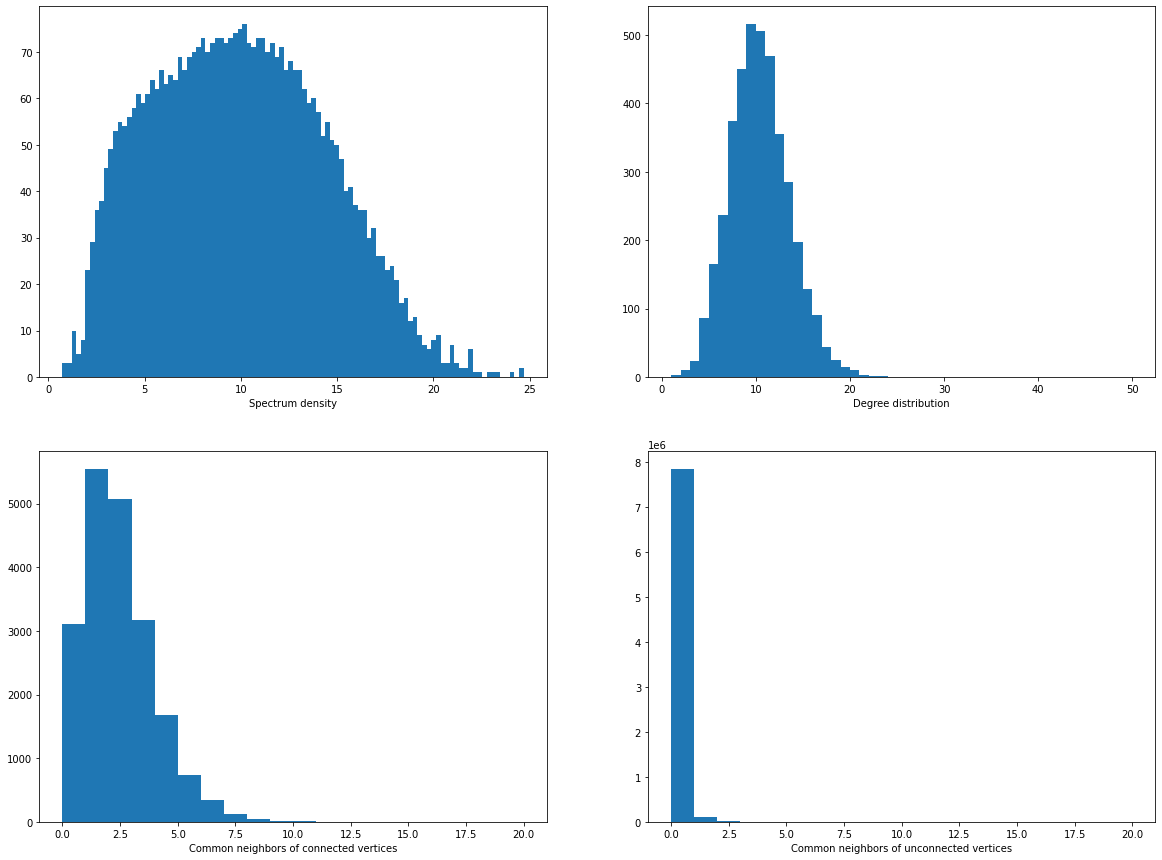

In [42]:
axs = show_plots(all_plots_list[0], (2,2), [["spectrum","degrees"], ["neigh_connected", "neigh_unconnected"]])

In [58]:
v = np.array([0.1, 2, 1, 0.1 2])

SyntaxError: invalid syntax. Perhaps you forgot a comma? (2507611831.py, line 1)

In [15]:
def cut_profile(A : np.array, S) -> int:
    in_S = np.full(A.shape[0], False)
    adj = adjecency_lists(A)
    cut = 0
    result = []
    for i in S:
        in_S[i] = True
        for j in adj[i]:
            cut += -1 if in_S[j] == 1 else 1
        result.append(cut)
    return result
        

In [16]:
def graph_cut_pair(n : int, p1 : float, d : int) -> np.array:
    h = threshold_from_density(d, p1)
    A = gaussian_orthogonal_ensemble(n, d)
    S = np.argsort(A[0,:], axis=None)
    
    A = (A > 1 - h).astype(int)
    for i in range(A.shape[0]):
        A[i,i] = 0
    return (A,S)

In [17]:
N = 15000

In [18]:
A_tmp, S_tmp = graph_cut_pair(N, 10/N, 25)

In [19]:
cut = cut_profile(A_tmp, S_tmp)

In [20]:
cut_2 = cut_profile(A_tmp, range(A_tmp.shape[0]))

## Size of the hyperplane cut compared to size of cut in G(n,p)

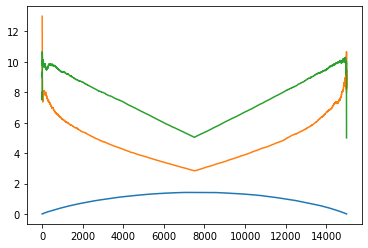

In [21]:
cut_a1 = np.array(cut[:-1])
cut_a2 = np.array(cut_2[:-1])
t = np.array([min(i, N-i) for i in range(1, N)])
x = np.linspace(1, N-1, N-1)
plt.plot(x, cut_a1/N)
plt.plot(x, cut_a1/t)
plt.plot(x, cut_a2/t)

In [26]:
cut_a1[400]/400

8.6625

In [84]:
t

array([1, 2, 3, ..., 3, 2, 1])

In [86]:
cut_a[0]

6

In [92]:
np.where(t  < 5)

(array([   0,    1,    2,    3, 3995, 3996, 3997, 3998]),)